[![nbviewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/deJong_Mackay_et_al_2023/convergence.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=examples/PySDM_examples/deJong_Mackay_et_al_2023/convergence.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/deJong_Mackay_et_al_2023/convergence.ipynb)

In [128]:
import os
import sys
from datetime import datetime
import json
from PySDM.physics import si
from PySDM_examples.Srivastava_1982 import coalescence_and_breakup_eq13, Settings
from open_atmos_jupyter_utils import show_plot

import numpy as np
from matplotlib import pyplot
from PySDM_examples.Srivastava_1982.simulation import Simulation
import numba

from PySDM.products import SuperDropletCountPerGridbox, VolumeFirstMoment, ZerothMoment
from PySDM.backends import GPU, CPU
from PySDM.dynamics import Collision
from PySDM.dynamics.collisions.breakup_efficiencies import ConstEb
from PySDM.dynamics.collisions.breakup_fragmentations import ConstantSize
from PySDM.dynamics.collisions.coalescence_efficiencies import ConstEc
from PySDM.dynamics.collisions.collision_kernels import ConstantK

In [129]:
def write_to_file(filename, d):
  assert not os.path.isfile(filename)

  with open(filename, "w") as fp:
    json.dump(d, fp)


def plot_processed_results(processed_d, show=True, plot_label='', plot_title=None, metric='min', plot_filename=None):
  x = []
  y = []

  backends = list(processed_d.keys())
  backends.sort()
  backends.sort(key=lambda x: int(x[6:]) if 'Numba_' in x else 100**10)

  markers = {backend: 'o' if 'Numba' in backend else 'x' for backend in backends}

  for backend in backends:
    for n_sd in processed_d[backend].keys():
      if n_sd not in x:
        x.append(n_sd)

  x.sort()

  for backend in backends:
    y = []
    for n_sd in x:
      v = processed_d[backend][n_sd][metric]
      y.append(v)

    pyplot.plot(x, y, label=backend+plot_label, marker=markers[backend])

  pyplot.legend()
  pyplot.xscale('log', base=2)
  pyplot.yscale('log', base=2)
  pyplot.grid()
  pyplot.xticks(x)
  pyplot.xlabel("number of super-droplets")
  pyplot.ylabel("wall time per timestep [s]")

  if plot_title:
    pyplot.title(plot_title)

  if show:
    show_plot(filename=plot_filename)


def plot_processed_on_same_plot(coal_d, break_d, coal_break_d):
  plot_processed_results(coal_d, plot_label='-c', show=False)
  plot_processed_results(break_d, plot_label='-b', show=False)
  plot_processed_results(coal_break_d, plot_label='-cb', show=False)

  show_plot()

# Analyse

In [130]:
folder_path = './perf_comp_results/'
result_files = os.listdir(folder_path)

In [131]:
result_files.sort()

In [132]:
result_files

['.ipynb_checkpoints',
 'gmum_cpu_env_info',
 'gmum_cpu_env_info-results-2023-09-10 14:41:16.920260-breakup.txt',
 'gmum_cpu_env_info-results-2023-09-10 14:41:16.920260-coal+breakup.txt',
 'gmum_cpu_env_info-results-2023-09-10 14:41:16.920260-coalescence.txt',
 'gmum_cpu_env_info-results-2023-09-10 19:58:49.400953-breakup-double.txt',
 'gmum_cpu_env_info-results-2023-09-10 19:58:49.400953-coal+breakup-double.txt',
 'gmum_cpu_env_info-results-2023-09-10 19:58:49.400953-coalescence-double.txt',
 'gmum_gpu_env_info2023-09-11_11:15:03.932285',
 'gmum_gpu_env_info2023-09-11_12:21:49.290521',
 'gmum_gpu_env_info2023-09-11_12:21:49.290521-results-2023-09-11 12:21:55.510294-breakup-single.txt',
 'gmum_gpu_env_info2023-09-11_12:21:49.290521-results-2023-09-11 12:21:55.510294-coal+breakup-single.txt',
 'gmum_gpu_env_info2023-09-11_12:21:49.290521-results-2023-09-11 12:21:55.510294-coal+breakup-single_1.txt',
 'gmum_gpu_env_info2023-09-11_12:21:49.290521-results-2023-09-11 12:21:55.510294-coalesc

In [133]:
def read_dict_from_file(filename):
    with open(filename, "r") as fp:
        d = json.load(fp)
        assert all(['Thrust' or 'Numba' in k for k in d.keys()])
        
        for backend in d.keys():
            for n_sd in d[backend]:
                assert str(int(n_sd)) == n_sd
                tmp = d[backend][n_sd]

                del d[backend][n_sd]
                d[backend][int(n_sd)] = tmp
        
        return d

# GPU

## Coalescence + Breakup

In [134]:
gmum_gpu_coal_breakup_single = read_dict_from_file(
    folder_path+
  'gmum_gpu_env_info2023-09-11_15:46:52.269988-results-2023-09-11 15:46:53.174685-coal+breakup-single.txt'
)

In [135]:
gmum_gpu_coal_breakup_single_weird_bump = read_dict_from_file(
    folder_path+
 'gmum_gpu_env_info2023-09-11_12:21:49.290521-results-2023-09-11 12:21:55.510294-coal+breakup-single.txt'
)

gmum_gpu_coal_breakup_double = read_dict_from_file(
    folder_path+
     'gmum_gpu_env_info2023-09-11_14:24:43.478501-results-2023-09-11 14:24:45.198449-coal+breakup-double.txt'
)

gmum_gpu_coal_breakup_single_wait = read_dict_from_file(
    folder_path+
    'gmum_gpu_env_info_wait_True_2023-09-11_17:11:01.151407-results-2023-09-11_17:11:01.151407-coal+breakup-single.txt'

)

gmum_gpu_coal_breakup_double_wait = read_dict_from_file(
    folder_path+
    'gmum_gpu_env_info_wait_True_2023-09-11_17:57:02.816929-results-2023-09-11 17:57:04.643939-coal+breakup-double.txt'
)

gpu_coal_breakup_different_configs = {
    'ThrustRTC-single': gmum_gpu_coal_breakup_single_weird_bump['ThrustRTC'], 
    'ThrustRTC-double': gmum_gpu_coal_breakup_double['ThrustRTC'],
    'ThrustRTC-single-wait': gmum_gpu_coal_breakup_single_wait['ThrustRTC'],
    'ThrustRTC-double-wait': gmum_gpu_coal_breakup_double_wait['ThrustRTC'],
}



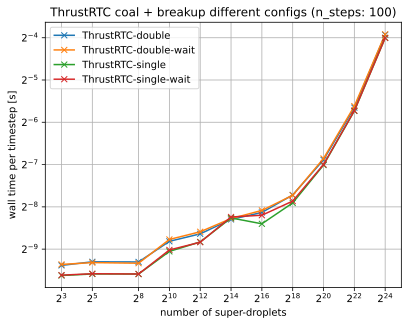

HTML(value="<a href='./tmp8x4kvi76.pdf' target='_blank'>./tmp8x4kvi76.pdf</a><br>")

In [136]:
plot_processed_results(
    gpu_coal_breakup_different_configs, 
    plot_title='ThrustRTC coal + breakup different configs (n_steps: 100)', metric='min'
)

## Breakup

In [137]:
gmum_gpu_breakup_single = read_dict_from_file(
    folder_path+
 'gmum_gpu_env_info2023-09-11_12:21:49.290521-results-2023-09-11 12:21:55.510294-breakup-single.txt'
)

gmum_gpu_breakup_double = read_dict_from_file(
    folder_path+
     'gmum_gpu_env_info2023-09-11_14:24:43.478501-results-2023-09-11 14:24:45.198449-breakup-double.txt'
)

gmum_gpu_breakup_single_wait = read_dict_from_file(
    folder_path+
    'gmum_gpu_env_info_wait_True_2023-09-11_17:11:01.151407-results-2023-09-11_17:11:01.151407-breakup-single.txt'

)

gmum_gpu_breakup_double_wait = read_dict_from_file(
    folder_path+
    'gmum_gpu_env_info_wait_True_2023-09-11_17:57:02.816929-results-2023-09-11 17:57:04.643939-breakup-double.txt'
)

gpu_breakup_different_configs = {
    'ThrustRTC-single': gmum_gpu_breakup_single['ThrustRTC'], 
    'ThrustRTC-double': gmum_gpu_breakup_double['ThrustRTC'],
    'ThrustRTC-single-wait': gmum_gpu_breakup_single_wait['ThrustRTC'],
    'ThrustRTC-double-wait': gmum_gpu_breakup_double_wait['ThrustRTC'],
}



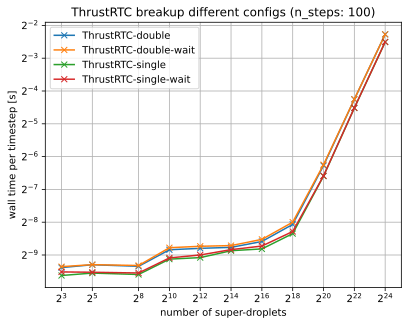

HTML(value="<a href='./tmpmj75rn1h.pdf' target='_blank'>./tmpmj75rn1h.pdf</a><br>")

In [138]:
plot_processed_results(
    gpu_breakup_different_configs, plot_title='ThrustRTC breakup different configs (n_steps: 100)', metric='min'
)

## Coalescence

In [139]:
gmum_gpu_coal_single = read_dict_from_file(
    folder_path+
 'gmum_gpu_env_info2023-09-11_12:21:49.290521-results-2023-09-11 12:21:55.510294-coalescence-single.txt'
)

gmum_gpu_coal_double = read_dict_from_file(
    folder_path+
     'gmum_gpu_env_info2023-09-11_14:24:43.478501-results-2023-09-11 14:24:45.198449-coalescence-double.txt'
)

gmum_gpu_coal_single_wait = read_dict_from_file(
    folder_path+
    'gmum_gpu_env_info_wait_True_2023-09-11_17:11:01.151407-results-2023-09-11_17:11:01.151407-coalescence-single.txt'

)

gmum_gpu_coal_double_wait = read_dict_from_file(
    folder_path+
    'gmum_gpu_env_info_wait_True_2023-09-11_17:57:02.816929-results-2023-09-11 17:57:04.643939-coalescence-double.txt'
)

gpu_coal_different_configs = {
    'ThrustRTC-single': gmum_gpu_coal_single['ThrustRTC'], 
    'ThrustRTC-double': gmum_gpu_coal_double['ThrustRTC'],
    'ThrustRTC-single-wait': gmum_gpu_coal_single_wait['ThrustRTC'],
    'ThrustRTC-double-wait': gmum_gpu_coal_double_wait['ThrustRTC'],
}



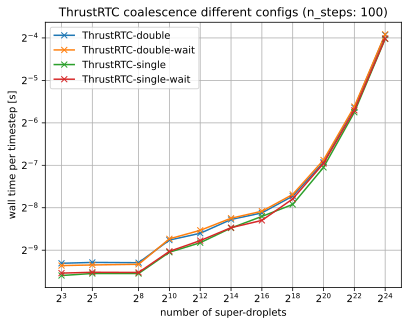

HTML(value="<a href='./tmpwft4_kts.pdf' target='_blank'>./tmpwft4_kts.pdf</a><br>")

In [140]:
plot_processed_results(
    gpu_coal_different_configs, plot_title='ThrustRTC coalescence different configs (n_steps: 100)', metric='min'
)

# CPU

## Coalescence + Breakup

In [141]:
gmum_cpu_coal_breakup_double_2 = read_dict_from_file(
    folder_path+'gmum_cpu_env_info-results-2023-09-10 19:58:49.400953-coal+breakup-double.txt'
)
gmum_cpu_coal_breakup_double_2

{'Numba_1': {8: {'mean': 6.724834442138672e-05,
   'std': 4.8012790050998e-07,
   'max': 6.791353225708008e-05,
   'min': 6.679773330688477e-05},
  32: {'mean': 6.857554117838543e-05,
   'std': 7.310872465386685e-07,
   'max': 6.955385208129883e-05,
   'min': 6.779670715332032e-05},
  256: {'mean': 7.707675298055014e-05,
   'std': 7.038433406094624e-07,
   'max': 7.792949676513672e-05,
   'min': 7.620573043823242e-05},
  1024: {'mean': 0.00010596116383870443,
   'std': 2.5387816182713884e-07,
   'max': 0.00010619163513183593,
   'min': 0.0001056075096130371},
  4096: {'mean': 0.0002440182367960612,
   'std': 6.196792058322818e-06,
   'max': 0.00025249481201171874,
   'min': 0.0002378535270690918},
  16384: {'mean': 0.0009155495961507162,
   'std': 4.340085413364398e-06,
   'max': 0.0009211373329162598,
   'min': 0.0009105563163757324},
  65536: {'mean': 0.0033183526992797852,
   'std': 2.7982995414028874e-05,
   'max': 0.0033547592163085936,
   'min': 0.0032867145538330077},
  262144: 

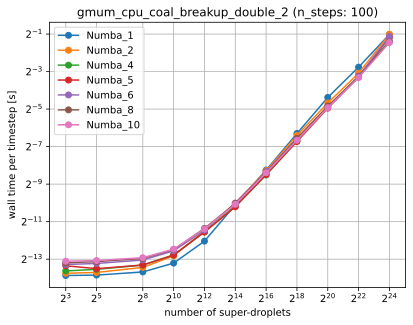

HTML(value="<a href='./tmpp88x7f81.pdf' target='_blank'>./tmpp88x7f81.pdf</a><br>")

In [142]:
plot_processed_results(gmum_cpu_coal_breakup_double_2, plot_title='gmum_cpu_coal_breakup_double_2 (n_steps: 100)', metric='min')

## Breakup

In [143]:
gmum_cpu_breakup_double_2 = read_dict_from_file(
    folder_path+'gmum_cpu_env_info-results-2023-09-10 19:58:49.400953-breakup-double.txt'
)
gmum_cpu_breakup_double_2

{'Numba_1': {8: {'mean': 6.847063700358073e-05,
   'std': 8.176084995592006e-07,
   'max': 6.908416748046875e-05,
   'min': 6.731510162353515e-05},
  32: {'mean': 6.940523783365884e-05,
   'std': 3.2794665979658337e-07,
   'max': 6.98685646057129e-05,
   'min': 6.915569305419922e-05},
  256: {'mean': 8.502006530761718e-05,
   'std': 6.09717934252941e-08,
   'max': 8.510589599609375e-05,
   'min': 8.496999740600586e-05},
  1024: {'mean': 0.0001383543014526367,
   'std': 7.191973269856387e-07,
   'max': 0.00013930320739746093,
   'min': 0.00013756275177001954},
  4096: {'mean': 0.00034558852513631185,
   'std': 2.5200361355281944e-06,
   'max': 0.0003491091728210449,
   'min': 0.00034334897994995115},
  16384: {'mean': 0.001244348684946696,
   'std': 2.128758245698301e-06,
   'max': 0.0012472915649414064,
   'min': 0.0012423276901245117},
  65536: {'mean': 0.005492118199666341,
   'std': 2.749572407041538e-05,
   'max': 0.005527126789093018,
   'min': 0.005459957122802735},
  262144: {'m

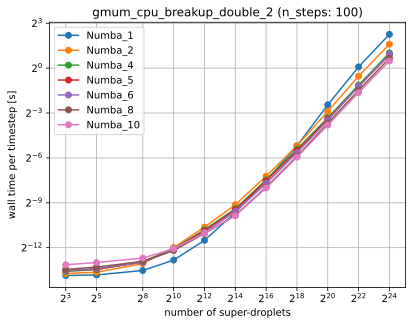

HTML(value="<a href='./tmpm6q01dh2.pdf' target='_blank'>./tmpm6q01dh2.pdf</a><br>")

In [144]:
plot_processed_results(gmum_cpu_breakup_double_2, plot_title='gmum_cpu_breakup_double_2 (n_steps: 100)', metric='min')

## Coalsescence

In [145]:
gmum_cpu_coalescence_double_2 = read_dict_from_file(
    folder_path+'gmum_cpu_env_info-results-2023-09-10 19:58:49.400953-coalescence-double.txt'
)
gmum_cpu_coalescence_double_2

{'Numba_1': {8: {'mean': 6.905396779378254e-05,
   'std': 1.5356603832819459e-06,
   'max': 7.052898406982422e-05,
   'min': 6.693601608276367e-05},
  32: {'mean': 6.815671920776366e-05,
   'std': 3.8067914579570075e-07,
   'max': 6.855010986328125e-05,
   'min': 6.764173507690429e-05},
  256: {'mean': 7.767597834269206e-05,
   'std': 1.2194550321028252e-06,
   'max': 7.940053939819335e-05,
   'min': 7.680892944335938e-05},
  1024: {'mean': 0.00035447676976521815,
   'std': 0.00035142734853904395,
   'max': 0.0008514690399169922,
   'min': 0.00010509490966796875},
  4096: {'mean': 0.0002462275822957357,
   'std': 2.9948823909584086e-06,
   'max': 0.0002491283416748047,
   'min': 0.00024210453033447266},
  16384: {'mean': 0.0009111976623535157,
   'std': 3.117198865645467e-05,
   'max': 0.000948948860168457,
   'min': 0.0008726072311401367},
  65536: {'mean': 0.0032597176233927407,
   'std': 1.7345206468915967e-05,
   'max': 0.0032841801643371583,
   'min': 0.0032459139823913575},
  262

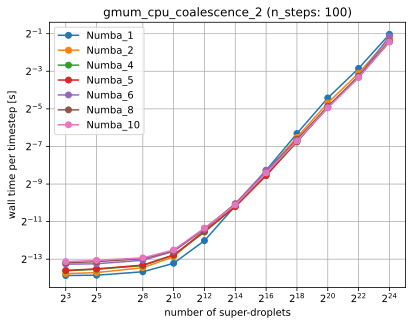

HTML(value="<a href='./tmpm36k37qr.pdf' target='_blank'>./tmpm36k37qr.pdf</a><br>")

In [146]:
plot_processed_results(gmum_cpu_coalescence_double_2, plot_title='gmum_cpu_coalescence_2 (n_steps: 100)', metric='min')


# CPU + GPU 

In [147]:
SELECTED_BACKENDS = ['Numba_1', 'Numba_5', 'Numba_10', 'ThrustRTC']

## Coalescence

In [148]:
gmum_coalescence_double = {**gmum_cpu_coalescence_double_2, **gmum_gpu_coal_double}

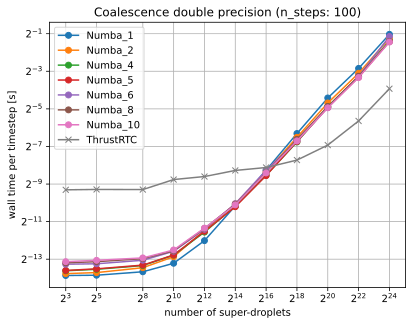

HTML(value="<a href='./tmpztcv3qvf.pdf' target='_blank'>./tmpztcv3qvf.pdf</a><br>")

In [149]:
plot_processed_results(
    gmum_coalescence_double, plot_title='Coalescence double precision (n_steps: 100)', metric='min'
)

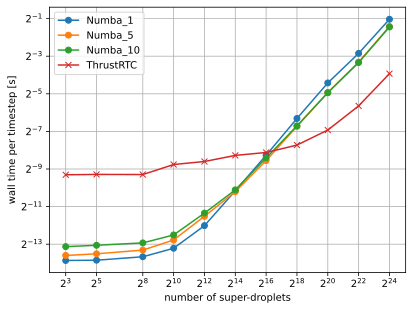

HTML(value="<a href='./coalescence_n_steps100_double_selected.pdf' target='_blank'>./coalescence_n_steps100_do…

In [150]:
gmum_coalescence_double_selected = { k: gmum_coalescence_double[k] for k in SELECTED_BACKENDS}

plot_processed_results(
    gmum_coalescence_double_selected, 
    plot_title=None, #'Coalescence double precision (n_steps: 100)', metric='min'
    plot_filename='coalescence_n_steps100_double_selected.pdf'
)

## Breakup

In [151]:
gmum_breakup_double = {**gmum_cpu_breakup_double_2, **gmum_gpu_breakup_double}

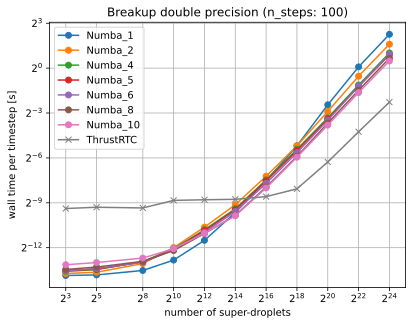

HTML(value="<a href='./tmpxtdogtrq.pdf' target='_blank'>./tmpxtdogtrq.pdf</a><br>")

In [152]:
plot_processed_results(
    gmum_breakup_double, plot_title='Breakup double precision (n_steps: 100)', metric='min'
)

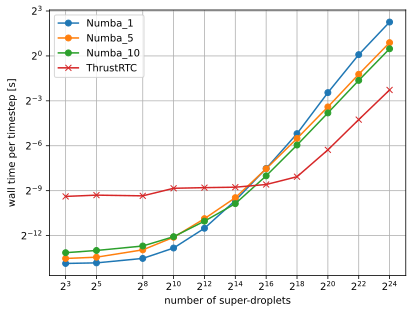

HTML(value="<a href='./breakup_n_steps100_double_selected.pdf' target='_blank'>./breakup_n_steps100_double_sel…

In [153]:
gmum_breakup_double_selected = { k: gmum_breakup_double[k] for k in SELECTED_BACKENDS}

plot_processed_results(
    gmum_breakup_double_selected, 
    plot_title=None, #'Breakup double precision (n_steps: 100)', metric='min'
    plot_filename='breakup_n_steps100_double_selected.pdf'
)

## Coalescence + Breakup

In [154]:
gmum_coal_breakup_double = {**gmum_cpu_coal_breakup_double_2, **gmum_gpu_coal_breakup_double}

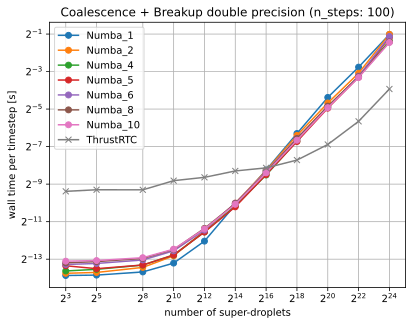

HTML(value="<a href='./tmpku9ob5v1.pdf' target='_blank'>./tmpku9ob5v1.pdf</a><br>")

In [155]:
plot_processed_results(
    gmum_coal_breakup_double, plot_title='Coalescence + Breakup double precision (n_steps: 100)', metric='min'
)

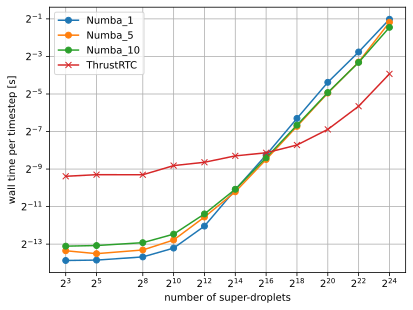

HTML(value="<a href='./coal_breakup_n_steps100_double_selected.pdf' target='_blank'>./coal_breakup_n_steps100_…

In [156]:
gmum_coal_breakup_double_selected = { k: gmum_coal_breakup_double[k] for k in SELECTED_BACKENDS}

plot_processed_results(
    gmum_coal_breakup_double_selected, 
    plot_title=None, #'Coalescence + Breakup double precision (n_steps: 100)', metric='min'
    plot_filename='coal_breakup_n_steps100_double_selected.pdf'
)

In [159]:
temp = {'coal_breakup': gmum_coal_breakup_double_selected['ThrustRTC'], 'coal': gmum_coalescence_double_selected['ThrustRTC']}

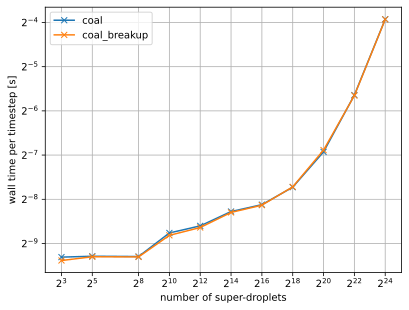

HTML(value="<a href='./temp' target='_blank'>./temp</a><br>")

In [162]:
plot_processed_results(
    temp, 
    plot_title=None, #'Coalescence + Breakup double precision (n_steps: 100)', metric='min'
    plot_filename='temp',
)